In [1]:
#do this later from admin: !python -m pip install --upgrade pip


# TOC

0. [Imports](#first-bullet)
1. [EDA](#1.0-bullet)
2. [Feature Engineering](#2.0-bullet)  
 2.1 [Pt 1 - Regression](#2.1-bullet)  
 2.2 [Pt 2 - Classification](#2.2-bullet)
3. [Basic Model](#3.0-bullet)  
 3.1 [Pt 1 - Regression](#3.1-bullet)  
 3.2 [Pt 2 - Classification](#3.2-bullet)
4. [Reference and Planning](#4.0-bullet)

# Do not Run All cells - lots of charts

In [1]:
#Basic
import pandas as pd
import numpy as np
#Math
import scipy as sp
from random import randint
from math import exp
import operator

#Scraping
import requests
import json

#Youtube Data API Packages: 
"""from apiclient.discovery import build
from apiclient.errors import HttpError
from oauth2client.tools import argparser
from googleapiclient.discovery import build
import argparse
from googleapiclient.errors import HttpError"""

#Modeling
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
#from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import r2_score,confusion_matrix, roc_auc_score, roc_curve

#NLP & Text Management
# from sklearn.feature_extraction import stop_words
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfVectorizer
# import re
# from textblob import TextBlob
# from wordcloud import WordCloud
# from nltk.stem import PorterStemmer

#Time analysis
import time
import datetime
# from statsmodels.tsa.stattools import pacf
# from statsmodels.graphics.tsaplots import plot_pacf

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
#from wordcloud import WordCloud

%matplotlib inline
plt.style.use('classic')
sns.set_style('whitegrid')

In [2]:
df_main = pd.read_csv('./data/engineered_data/data_genres.csv')

In [3]:
model_time = ['is_weekend', 'is_friday', 'year_day', 'week', 'week_day', 'month', 'month_day', 'year',  ]
model_text = ['description_sentiment', 'description_wordcount',
  'tags_sentiment', 'tags_wordcount', 'title_sentiment',
 'title_wordcount', 'title_featuring', 'title_length', ]
model_title_letter = ['intitle_a',  'intitle_b', 'intitle_c', 'intitle_d', 'intitle_e', 'intitle_f', 'intitle_g',
 'intitle_h', 'intitle_i', 'intitle_j', 'intitle_k', 'intitle_l', 'intitle_m', 'intitle_n', 'intitle_o',
 'intitle_p', 'intitle_q', 'intitle_r', 'intitle_s', 'intitle_t', 'intitle_u', 'intitle_v', 'intitle_w',
 'intitle_x', 'intitle_y', 'intitle_z',]              
model_ratios = ['lv_ratio', 'comment_view_ratio', 'like_dislike_ratio',]
model_other = ['duration', 'contentRating', 'regionRestriction',  'licensedContent', 'caption', 'definition']
measures = ['likeCount', 'dislikeCount', 'commentCount', 'viewCount',
            'view_log',  'comment_log',  'like_log', 'dislike_log', 
            'view_class' ]
non_model_cols = ['request_token', 'letter_search','channelTitle', 'tags', 'title', 'vidId','publishedAt','favoriteCount',
              'description','defaultLanguage', ]

In [4]:
genre_list_str = ['alt_words', 'blues_words', 'christian_words', 'classical_words', 'country_words', 'dubstep_words', 
                 'edm_words', 'extended_words', 'folk_words', 'halloween_words', 'hit_words', 'italian_words', 'jazz_words', 
                 'kpop_words', 'latin_words', 'love_songs', 'other_rock_words', 'pop_words', 'rap_words', 'remix_words', 
                 'reggae_words', 'romanian_words', 'relax_words', 'rock_words', 'trap_words']

# <a class="anchor" id="3.0-bullet"> 3. Basic Model</a>

In [5]:
def get_model_data(exclude_ratios=True, additional_cols_exclude=None, include_text_vecs=False, 
                   additional_cols_include=None, target=df_main.view_log, data=df_main):
    data=data
    if include_text_vecs:
        df_description = pd.read_csv('./data/engineered_data/description_wordvec.csv')
        df_tag = pd.read_csv('./data/engineered_data/tag_wordvec.csv')
        df_title = pd.read_csv('./data/engineered_data/title_wordvec.csv')
        df_combined = df_description.join(df_tag.set_index('vidId'), on=df_description['vidId'], how='left', rsuffix='tag')
        df_combined = df_combined.join(df_title.set_index('vidId'), on=df_combined['vidId'], how='left', rsuffix='title')

        cols_exclude_text = [col for col in df_combined.columns if '_word_' not in str(col)]
        cols_include_initial_text = [col for col in df_combined.columns if col not in cols_exclude]

        df_formodel = data.join(df_combined.set_index('vidId'), on=data['vidId'], how='left', rsuffix='text_combo')

    else:
        df_formodel = data
        
    cols_alphabet = ['intitle_a', 'intitle_d', 'intitle_f', 'intitle_g', 'intitle_i', 
                     'intitle_k', 'intitle_l','intitle_p','intitle_v','intitle_x','intitle_y' ]
    
    cols_exclude = ['vidId', 'year_day', 'month', 'tags_sentiment','title_sentiment', 'title_wordcount' ,
                    'titletext_combo', 'tagstext_combo', 'descriptiontext_combo', 'description', 'tags', 'title', 'view_log', 
                   'view_logtitle', 'view_logtag', 'Unnamed: 0title', 'Unnamed: 0']
    #
    
    if exclude_ratios:
        cols_exclude += ['lv_ratio', 'comment_view_ratio', 'like_dislike_ratio']
    if additional_cols_exclude!=None:
        cols_exclude+=additional_cols_exclude

    cols_include = [col for col in df_formodel.columns if \
    (col in model_time or \
    col in model_text or \
    col in cols_alphabet or \
    col in model_ratios or \
    col in model_other ) and \
    col not in cols_exclude]
    
    if additional_cols_include!=None:
        cols_include+=additional_cols_include

    df_formodel = df_formodel[df_formodel['view_class']>1]     
        
    y = target
    X = df_formodel.loc[:, cols_include]
    X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=30)

    ss = StandardScaler()
    X_train_sc = ss.fit_transform(X_train)
    X_test_sc = ss.transform(X_test)
    
    return X_train_sc, X_test_sc, y_train, y_test, ss, df_formodel, cols_include

NameError: name 'df_formodel' is not defined

## <a class="anchor" id="3.1-bullet">3.1 Unsupervised Learning</a>



### KMeans

In [10]:
from sklearn.cluster import DBSCAN, KMeans

In [11]:
from sklearn.metrics import silhouette_score

In [7]:
X_train_sc, X_test_sc, y_train, y_test, ss, df_formodel, cols_include = get_model_data()

class_columns_downselect = ['tags_sentiment', 'description_sentiment', 'description_wordcount', 'title_featuring', 'duration', 'year', 'title_length', 'lv_ratio', 'view_log']

In [31]:
uns_X = df_formodel.loc[:, class_columns_downselect]

ss2 = StandardScaler()
uns_X_sc = ss.fit_transform(uns_X)

In [32]:
for i in range(5, 15):
    classifier = KMeans(n_clusters=i, random_state=43)
    classifier.fit(uns_X_sc)
    k_classes = classifier.predict(uns_X_sc)
    #df_classified = df_main[df_main.view_class>1]
    #df_classified['kclass'] = k_classes
    print('    i: {}, inertia: {}, silhouette: {}'.format(i, classifier.inertia_, silhouette_score(uns_X_sc, k_classes)))

    i: 5, inertia: 47644.85587557956, silhouette: 0.1833405097923461
    i: 6, inertia: 43875.011335112074, silhouette: 0.18030994772429798
    i: 7, inertia: 40189.220688611225, silhouette: 0.18737606063197915
    i: 8, inertia: 37848.92087967569, silhouette: 0.1850749363276883
    i: 9, inertia: 35937.57718066239, silhouette: 0.18960513498661472
    i: 10, inertia: 34396.076313677295, silhouette: 0.19106046997472512
    i: 11, inertia: 33038.531816800736, silhouette: 0.1840860586227036
    i: 12, inertia: 32033.324027876377, silhouette: 0.18419610743984383
    i: 13, inertia: 31189.987949158505, silhouette: 0.18405425765385128
    i: 14, inertia: 30540.765553891146, silhouette: 0.1698511202981146


In [71]:
classifier = KMeans(n_clusters=13, random_state=43)
classifier.fit(uns_X_sc)
k_classes = classifier.predict(uns_X_sc)
df_classified = df_main[df_main.view_class>1].reset_index()
df_classified['kclass'] = k_classes
print('    i: {}, inertia: {}, silhouette: {}'.format(i, classifier.inertia_, silhouette_score(uns_X_sc, k_classes)))

    i: 8, inertia: 31189.987949158505, silhouette: 0.18405425765385128


In [38]:
df_classified[df_classified.title.str.contains('Despacito')].loc[:, ['title', 'viewCount', 'kclass']]

,title,viewCount,kclass
3232,Luis Fonsi - Despacito ( cover by J.Fla ),127411039,4
7398,Luis Fonsi - Despacito ft. Daddy Yankee,5555912002,7
7513,"Luis Fonsi, Daddy Yankee - Despacito (Remix Au...",633857377,7


In [103]:
df_classified.fillna('', inplace=True)

In [73]:
df_classified.loc[:, class_columns_downselect+['kclass']].groupby(by='kclass').mean()

,tags_sentiment,description_sentiment,description_wordcount,title_featuring,duration,year,title_length,lv_ratio,view_log
kclass,,,,,,,,,
0,0.008226,0.039581,47.900913,0.000652,345.873533,9.735332,36.730769,0.633219,6.644085
1,0.052835,0.137680,79.898721,0.000000,589.391258,15.546908,75.908316,0.656809,6.142468
2,0.073386,0.158831,412.233129,1.000000,269.932515,15.453988,59.858896,0.697495,7.121626
3,0.001664,0.064802,62.897872,0.000000,299.748227,16.556738,38.205674,0.711459,6.857065
4,0.022510,0.077000,47.695187,0.016043,322.750446,13.695187,43.178253,0.236871,3.435735
5,0.089934,0.154674,149.511494,0.000000,6426.379310,15.655172,65.442529,0.599872,5.810028
6,0.080599,0.133410,431.672897,0.000000,478.200000,14.629907,53.426168,0.675035,6.814603
7,0.500041,0.265363,84.820205,0.027397,383.638699,13.994863,45.232877,0.674158,6.717402
8,0.060081,0.175355,59.243243,1.000000,274.232848,14.976091,55.780665,0.696205,6.967625


In [113]:
for i in range(13):
     print('   ', i, df_classified[df_classified.kclass==i].shape[0])

    0 1534
    1 938
    2 163
    3 1410
    4 561
    5 174
    6 535
    7 584
    8 962
    9 712
    10 821
    11 15
    12 193


In [77]:
k_clusters = pd.DataFrame(classifier.cluster_centers_, columns=class_columns_downselect)
k_clusters

,tags_sentiment,description_sentiment,description_wordcount,title_featuring,duration,year,title_length,lv_ratio,view_log
0,-0.255709,-0.385626,-0.354787,-0.403102,-0.134680,-1.302659,-0.531651,0.004578,0.256073
1,-0.026598,0.026914,-0.102194,-0.404976,0.038132,0.403893,1.443233,0.177677,-0.061764
2,0.078952,0.115859,2.521275,2.469283,-0.188572,0.376607,0.634204,0.476221,0.558656
3,-0.289420,-0.279755,-0.236635,-0.404976,-0.166091,0.700310,-0.457168,0.577974,0.390607
4,-0.180556,-0.225935,-0.357069,-0.358700,-0.150783,-0.140705,-0.204987,-2.907848,-1.776577
5,0.163942,0.098376,0.447333,-0.404976,4.180350,0.435684,0.915667,-0.240121,-0.272408
6,0.115996,0.008958,2.674734,-0.404976,-0.040775,0.134618,0.309940,0.311414,0.364118
7,2.270244,0.563860,-0.063344,-0.326229,-0.107880,-0.051861,-0.103072,0.304978,0.302529
8,0.010614,0.185348,-0.265250,2.469283,-0.185520,0.236274,0.428627,0.466756,0.461077
9,-0.003390,1.684616,-0.247856,-0.344423,-0.145825,-0.379880,-0.491601,0.373355,0.553128


In [94]:
k_classes[5]

3

In [98]:
temp = 3
sum((uns_X_sc[temp] - k_clusters.iloc[k_classes[temp],:])**2)**.5

1.2072514971939474

In [105]:
dist_list = []
for i in range(len(uns_X_sc)):
    dist_list.append(sum((uns_X_sc[i] - k_clusters.iloc[k_classes[i],:])**2)**.5)

In [106]:
df_classified['dist_to_center'] = dist_list

In [110]:
df_classified = df_classified.sort_values(by='dist_to_center').reset_index()

In [112]:
df_classified.groupby(by='kclass').mean()['dist_to_center']

kclass
0     1.358737
1     1.717837
2     2.061603
3     1.345147
4     2.124534
5     2.741831
6     2.232974
7     2.080833
8     1.899842
9     1.745750
10    1.712398
11    5.044211
12    2.819984
Name: dist_to_center, dtype: float64

In [111]:
#df_classified.to_csv('./data/classifieds/k_classified_distances_v2.csv', index=False)

### DBScan

In [18]:
db_model = DBSCAN()

pd.DataFrame(db_model.fit_predict(uns_X_sc), columns=['class'])['class'].value_counts()

-1     8529
 0       15
 7        7
 5        7
 3        7
 10       7
 2        7
 1        6
 6        5
 4        5
 9        5
 8        2
Name: class, dtype: int64

In [138]:
db_preds = db_model.fit_predict(uns_X_sc)
df_db_classes = df_main[df_main.view_class>1]

In [139]:
df_db_classes['db_class'] = db_preds

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## <a class="anchor" id="3.2-bullet">3.2 Supervised Classification</a>



### 3.2.1 Classification - Gradient Boost

In [20]:
X_train_sc, X_test_sc, y_train, y_test, ss, df_formodel, cols_include = get_model_data(target=df_main[df_main.view_class>1].view_class)

In [21]:
gb = GradientBoostingClassifier()
gb.fit(X_train_sc, y_train)

preds = gb.predict(X_test_sc)

In [22]:
cm = confusion_matrix(y_test, preds)
pd.DataFrame(cm, columns=range(2,10), index=range(2,10))

,2,3,4,5,6,7,8,9
2,34,12,4,12,44,2,0,0
3,11,21,16,23,65,7,0,0
4,9,19,22,43,80,16,0,0
5,7,5,17,81,181,49,1,0
6,10,5,11,84,288,189,12,0
7,2,3,2,20,199,294,21,1
8,1,0,0,6,45,128,33,0
9,0,0,0,0,1,11,4,0


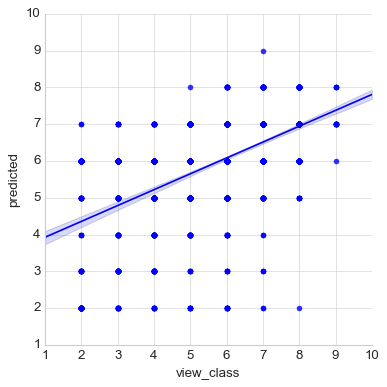

In [14]:
df_residuals = pd.DataFrame(y_test)
df_residuals['predicted'] = preds
df_residuals['residuals'] = df_residuals.predicted - df_residuals.view_class
sns.lmplot('view_class', 'predicted', data=df_residuals)

In [158]:
r2_score(df_residuals.view_class, df_residuals.predicted)


0.23393125202470566

In [34]:
df_big = df_main[df_main.viewCount > 100000000]
df_big_ss = ss.transform(df_big.loc[:, cols_include_initial])

df_big['predicted'] = 10**model.predict(df_big_ss)

#df_big.viewCount = df_big.viewCount.map(lambda x: '{:.6g}'.format(x))

df_big.loc[:, ['title', 'viewCount', 'predicted']].sort_values(by='viewCount', ascending=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,title,viewCount,predicted
7479,Luis Fonsi - Despacito ft. Daddy Yankee,5555912002,1000000000
4268,Ed Sheeran - Shape of You [Official Video],3827104659,1000000000
7190,Wiz Khalifa - See You Again ft. Charlie Puth [...,3788737518,1000000000
5540,Mark Ronson - Uptown Funk ft. Bruno Mars,3256917992,1000000000
3634,PSY - GANGNAM STYLE(강남스타일) M/V,3218413082,1000000000
569,Justin Bieber - Sorry (PURPOSE : The Movement),3014897224,1000000000
7417,Maroon 5 - Sugar,2756205542,1000000000
7514,Taylor Swift - Shake It Off,2650920924,1000000000
5506,Katy Perry - Roar (Official),2638406673,1000000000
627,Enrique Iglesias - Bailando (Español) ft. Desc...,2582945265,100000000


## <a class="anchor" id="3.2-bullet">3.2 KClass binary</a>



In [24]:
X_train, X_test, y_train, y_test, ss, df_formodel, cols_include = get_model_data(target=df_main[df_main.view_class>1].view_class.map(lambda x: 1 if x >= 8 else 0))

In [25]:
gb_bin = GradientBoostingClassifier()
gb_bin.fit(X_train_sc, y_train)
gb_bin.score(X_test_sc, y_test)

0.8949325894932589

In [26]:
preds = gb_bin.predict_proba(X_test_sc)
print('    accuracy: ', gb_bin.score(X_test_sc, y_test), 'roc: ', roc_auc_score(y_test, [element[1] for element in preds]))

    accuracy:  0.8949325894932589 roc:  0.8353925359773525


In [27]:
cm = confusion_matrix(y_test, gb_bin.predict(X_test_sc))
pd.DataFrame(cm)

,0,1
0,1908,14
1,212,17


## <a class="anchor" id="3.3-bullet">3.3 Neural Net</a>



In [28]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [29]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [ ]:
model = Sequential()
#this does input and first activation
model.add(Dense(X_train_sc.shape[1], activation='relu', input_dim=X_train_sc.shape[1]))
model.add(Dropout(.5))
model.add(Dense(20, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(10, activation='relu'))

model.add(Dense(y_train_cat.shape[1], activation='softmax')) #1 neuron
model.compile(loss='categorical_crossentropy', optimizer='adam')

history = model.fit(X_train_sc, y_train_cat, validation_data=(X_test_sc, y_test_cat), epochs=100, verbose=0)
preds = model.predict(X_test_sc)

In [35]:
preds_list = []
for element in preds:
    if element[0] > element[1]:
        preds_list.append(0)
    else:
        preds_list.append(1)

In [39]:
roc_auc_score(y_test, preds_list)

0.5

## <a class="anchor" id="3.2-bullet">3.2 Interpretation and Advanced Cleaning</a>


# <a class="anchor" id="4.0-bullet"> 4.0 Reference and Planning</a>